In [1]:
from SL_C0de.grid import ICE_TIME_GRID
from SL_C0de.grid import SEDIMENT_TIME_GRID
from SL_C0de.grid import TOPOGRAPHIC_TIME_GRID
from SL_C0de.grid import OCEAN_TIME_GRID

maxdeg=64

In [2]:
ice_time_grid=ICE_TIME_GRID(from_file=(True,'ice_grid_64'))
sed_time_grid=SEDIMENT_TIME_GRID(from_file=(True,'sed_grid_64'))
topo_time_grid=TOPOGRAPHIC_TIME_GRID(from_file=(True,'topo_grid_64'))

# For the initialization, we need to update the ice as a corrected ice

In [3]:
ocean_time_grid=OCEAN_TIME_GRID()
ocean_time_grid.evaluate_ocean(topo_time_grid.height_time_grid[0,:,:])

In [4]:
ice_time_grid.ice_correction(topo_time_grid,ocean_time_grid)
ice_time_grid.timegrdtotimecoeff()

# For the model computation, we need the love numbers. 

In [5]:
from SL_C0de.love import LOVE
maxdeg=64
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

stop=120 # define the number of time steps
step=1
time_step=np.arange(start=stop,stop=0,step=-step)
print(time_step)
love_number=LOVE(maxdeg,'C:/Users/ahenry01/Desktop/Python_code/SL_C0de_data/VM5a_122',time_step,6371000,5.9742e24)

[120 119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103
 102 101 100  99  98  97  96  95  94  93  92  91  90  89  88  87  86  85
  84  83  82  81  80  79  78  77  76  75  74  73  72  71  70  69  68  67
  66  65  64  63  62  61  60  59  58  57  56  55  54  53  52  51  50  49
  48  47  46  45  44  43  42  41  40  39  38  37  36  35  34  33  32  31
  30  29  28  27  26  25  24  23  22  21  20  19  18  17  16  15  14  13
  12  11  10   9   8   7   6   5   4   3   2   1]


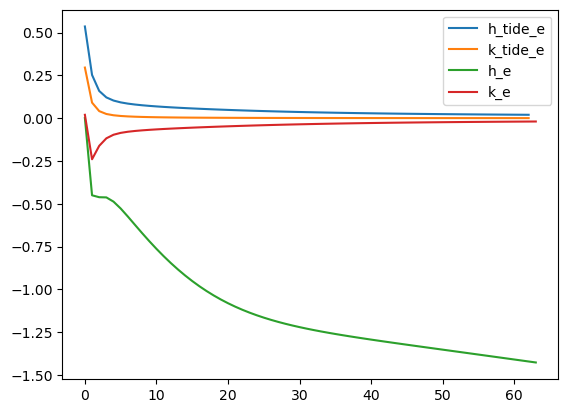

In [6]:
import matplotlib.pyplot as plt
plt.plot(love_number.h_tide_e[1:],label='h_tide_e')
plt.plot(love_number.k_tide_e[1:],label='k_tide_e')
plt.plot(love_number.h_e,label='h_e')
plt.plot(love_number.k_e,label='k_e')
plt.legend()
plt.show()

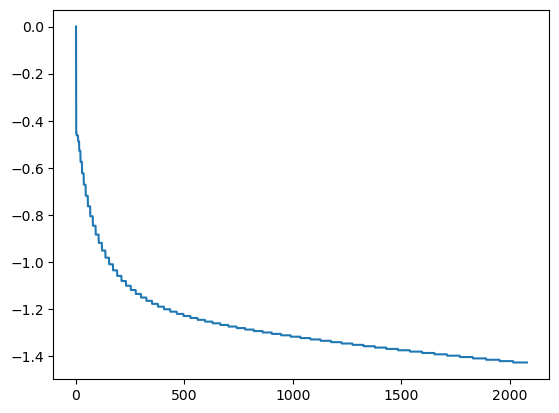

In [7]:
import matplotlib.pyplot as plt 
plt.plot(love_number.h)
plt.show()

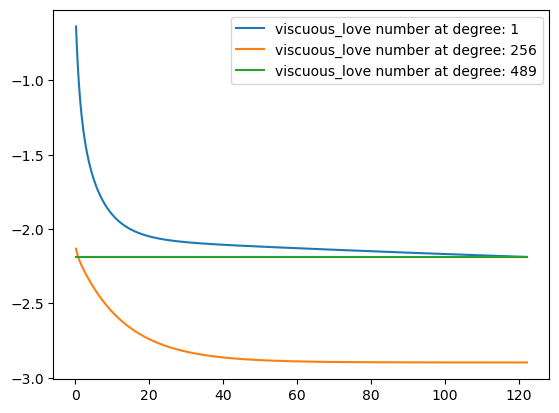

In [8]:
import matplotlib.pyplot as plt
from numpy.matlib import repmat
plt.plot(love_number.love_time,love_number.h_ve[1:-1,1],label='viscuous_love number at degree: ' + str(1))
plt.plot(love_number.love_time,love_number.h_ve[1:-1,int(love_number.h_ve.shape[1]/4)],label='viscuous_love number at degree: ' + str(int(love_number.h_ve.shape[1]/4)))
plt.plot(love_number.love_time,love_number.h_ve[1:-1,-1],label='viscuous_love number at degree: ' + str(love_number.h_ve.shape[0]-2))
plt.legend()
plt.show()

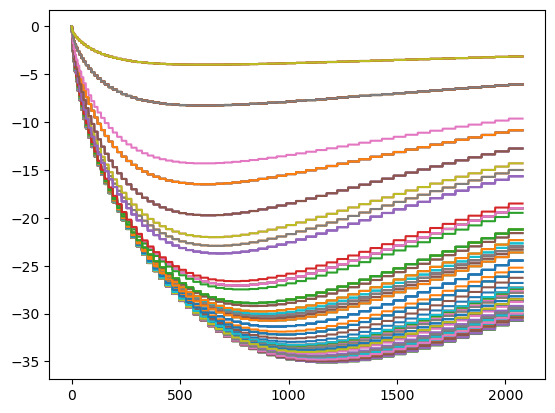

In [9]:
import matplotlib.pyplot as plt
from numpy.matlib import repmat
plt.plot(love_number.beta_R_l[118,:].T)
plt.show()

# Now we have defined the love numbers and adapted them to our model, we can calculate the subsidence and Geoïd deformation

In [24]:
from SL_C0de.Load import LOAD

In [25]:
load=LOAD(maxdeg,time_step)

In [26]:
t_it=1
if t_it==1 :
    load.calc_viscuous_load(ice_time_grid.height_time_coeff[0].copy()*ice_time_grid.rho,love_number.beta_R_l,t_it-1)
else :
    load.calc_viscuous_load(ice_time_grid.height_time_coeff[:t_it-1].copy()*ice_time_grid.rho,love_number.beta_R_l,t_it-1)
load.V_lm.maxdeg=64
load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
hd_visc=load.V_lm.coefftogrdhd(1024)

In [27]:
from SL_C0de.spharm import sphericalobject
subs_e=sphericalobject(coeff=ice_time_grid.height_time_coeff[:t_it].sum(0)*ice_time_grid.rho*love_number.h*love_number.T.coeff)
subs_e.maxdeg=64
hd_elast=subs_e.coefftogrdhd(1024)

In [28]:
total_subsidence=hd_elast+hd_visc

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_3032\1260078769.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


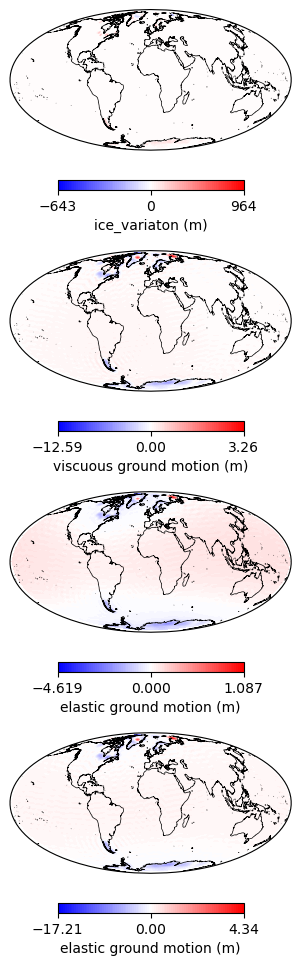

In [29]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors

cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm1 = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
ax1  = plt.subplot(411, projection=ccrs.Mollweide())
ax1.set_global()
colormap = cmap
m1 = ax1.imshow(ice_time_grid.height_time_grid[:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm1)
cbar1=plt.colorbar(mappable=m1, orientation="horizontal", shrink=0.2,ax=ax1)
cbar1.set_label('ice_variaton (m)')
cbar1.set_ticks([ice_time_grid.height_time_grid[:t_it,:,:].sum(0).min(), 0, ice_time_grid.height_time_grid[:t_it,:,:].sum(0).max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm2 = colors.TwoSlopeNorm(vmin=hd_visc.min(),vmax=hd_visc.max(),vcenter=0)
ax2  = plt.subplot(412, projection=ccrs.Mollweide())
ax2.set_global()
colormap = cmap
m2 = ax2.imshow(hd_visc, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm2)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.2,ax=ax2)
cbar2.set_label('viscuous ground motion (m)')
cbar2.set_ticks([hd_visc.min(), 0, hd_visc.max()])
ax2.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax2.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm3 = colors.TwoSlopeNorm(vmin=hd_elast.min(),vmax=hd_elast.max(),vcenter=0)
ax3  = plt.subplot(413, projection=ccrs.Mollweide())
ax3.set_global()
colormap = cmap
m3 = ax3.imshow(hd_elast, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
cbar3.set_label('elastic ground motion (m)')
cbar3.set_ticks([hd_elast.min(), 0, hd_elast.max()])
ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm4 = colors.TwoSlopeNorm(vmin=total_subsidence.min(),vmax=total_subsidence.max(),vcenter=0)
ax4  = plt.subplot(414, projection=ccrs.Mollweide())
ax4.set_global()
colormap = cmap
m4 = ax4.imshow(total_subsidence, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm4)
cbar4=plt.colorbar(mappable=m4, orientation="horizontal", shrink=0.2,ax=ax4)
cbar4.set_label('elastic ground motion (m)')
cbar4.set_ticks([total_subsidence.min(), 0, total_subsidence.max()])
ax4.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax4.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [19]:
fig.savefig('test.pdf')

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_4696\873594385.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2=cm.get_cmap('bwr', 100)
C:\Users\ahenry01\AppData\Local\Temp\ipykernel_4696\873594385.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1=cm.get_cmap('Blues', 100)


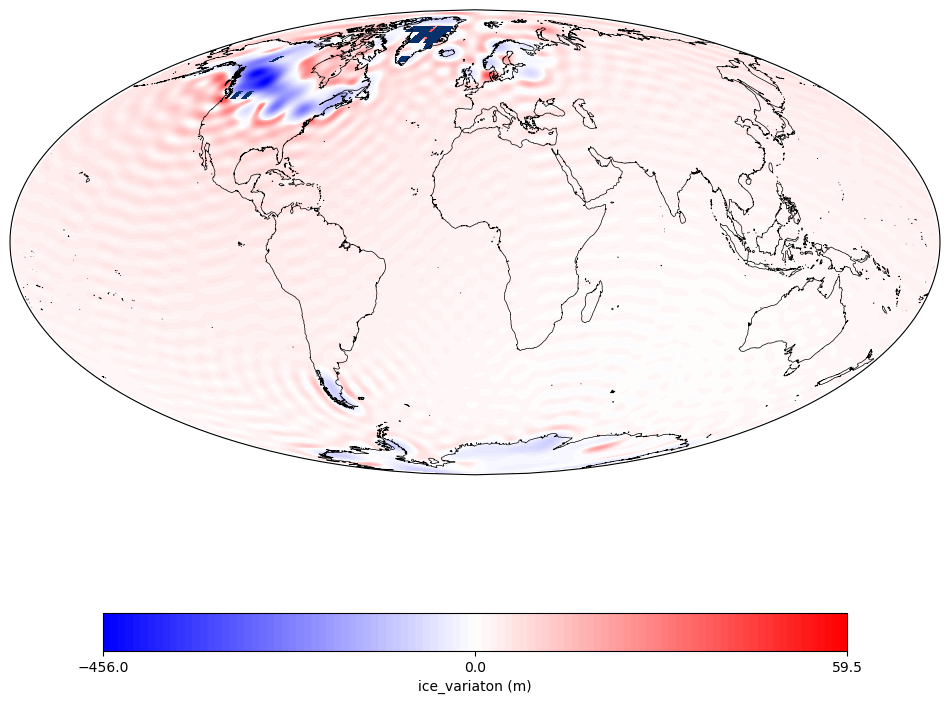

In [15]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors

cmap2=cm.get_cmap('bwr', 100)
cmap1=cm.get_cmap('Blues', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

clean_grid=ice_time_grid.height_time_grid[t_it,:,:].copy()
clean_grid[clean_grid<=0]=0
clean_grid[clean_grid>0]=1

norm1 = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
norm2 = colors.TwoSlopeNorm(vmin=total_subsidence.min(),vmax=total_subsidence.max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(total_subsidence, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap2, interpolation="gaussian",norm=norm2)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('ice_variaton (m)')
cbar2.set_ticks([total_subsidence.min(), 0, total_subsidence.max()])
m1 = ax1.imshow(clean_grid, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap1, interpolation="none",norm=norm1,alpha=clean_grid)
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [18]:
fig.savefig('ice_cap.pdf')

# Calculating_every time_step

In [29]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")
for t_it in range (ice_time_grid.time_step_number) :
    if t_it==0:
        hd_visc=np.zeros((1025,1025*2))
    elif t_it==1 :
        load.calc_viscuous_load(ice_time_grid.height_time_coeff[0]*ice_time_grid.rho,love_number.beta_R_l,t_it-1)
        load.V_lm.maxdeg=64
        load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
        hd_visc=load.V_lm.coefftogrdhd(1024)
    else :
        load.calc_viscuous_load(ice_time_grid.height_time_coeff[:t_it-1]*ice_time_grid.rho,love_number.beta_R_l,t_it-1)
        load.V_lm.maxdeg=64
        load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
        hd_visc=load.V_lm.coefftogrdhd(1024)
    if t_it==0 :
        subs_e=sphericalobject(coeff=ice_time_grid.height_time_coeff[0]*ice_time_grid.rho*(love_number.h)*love_number.T.coeff)
    else :
        subs_e=sphericalobject(coeff=ice_time_grid.height_time_coeff[:t_it].sum(0)*ice_time_grid.rho*(love_number.h)*love_number.T.coeff)
    subs_e.maxdeg=64
    hd_elast=subs_e.coefftogrdhd(1024)

    total_subs=hd_elast+hd_visc

    norm3 = colors.TwoSlopeNorm(vmin=-500,vmax=100,vcenter=0)
    ax3  = plt.subplot(111, projection=ccrs.Mollweide())
    ax3.set_global()
    colormap = cmap
    m3 = ax3.imshow(total_subs, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
    if t_it==0 :
        c=ax3.contour(ice_time_grid.elons,ice_time_grid.lats[::-1],ice_time_grid.height_time_grid[0,:,:],[0],linewidths=2,transform=ccrs.PlateCarree(),colors='b')
    else :
        c=ax3.contour(ice_time_grid.elons,ice_time_grid.lats[::-1],ice_time_grid.height_time_grid[:t_it,:,:].sum(0),[0],linewidths=2,transform=ccrs.PlateCarree(),colors='b')
    ax3.plot([-100,-200],[-100,-200],linewidth=2,color='b',label='ice extent')
    cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
    cbar3.set_label('elastic ground motion at ' + str(ice_time_grid.time_step[t_it]) + ' (m)')
    cbar3.set_ticks([-500, 0, 100])
    ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
    ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)
    ax3.legend()
    fig.savefig('Results/ice'+str(t_it))

    plt.clf()
    

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_1912\785860.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


<Figure size 1200x1200 with 0 Axes>

In [52]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")
for t_it in range (ice_time_grid.time_step_number) :
    norm3 = colors.TwoSlopeNorm(vmin=-3000,vmax=3000,vcenter=0)
    ax3  = plt.subplot(111, projection=ccrs.Mollweide())
    ax3.set_global()
    colormap = cmap
    m3 = ax3.imshow(ice_time_grid.height_time_grid[:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
    cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
    cbar3.set_label('elastic ground motion at ' + str(ice_time_grid.time_step[t_it]) + ' (m)')
    cbar3.set_ticks([-3000,0,3000])
    ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
    ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)
    fig.savefig('Results_ice/ice'+str(t_it))

    plt.clf()

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_13352\747978904.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


<Figure size 1200x1200 with 0 Axes>

# Now we have worked on the ice we can try to see what's going on with the sediments. 

In [10]:
from SL_C0de.Load import LOAD

In [11]:
load=LOAD(maxdeg,time_step)

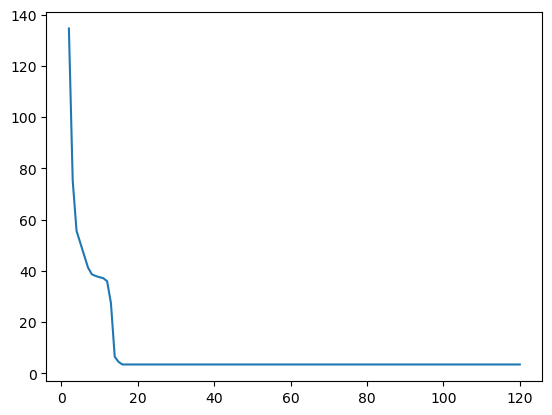

In [12]:
plt.plot(sed_time_grid.time_step,sed_time_grid.height_time_grid.sum(-1).sum(-1).cumsum())

In [13]:
sed_time_grid.timegrdtotimecoeff()

In [22]:
t_it=115
load.calc_viscuous_load(-sed_time_grid.height_time_coeff[:t_it-1,:]*sed_time_grid.rho,love_number.beta_l,t_it-1)
load.V_lm.maxdeg=64
load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
hd_visc=load.V_lm.coefftogrdhd(1024)

In [23]:
from SL_C0de.spharm import sphericalobject
subs_e=sphericalobject(coeff=-sed_time_grid.height_time_coeff[:t_it,:].sum(0)*sed_time_grid.rho*(love_number.k-love_number.h)*love_number.T.coeff)
subs_e.maxdeg=64
hd_elast=subs_e.coefftogrdhd(1024)

In [24]:
total_subsidence=hd_elast+hd_visc

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_1656\310232321.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


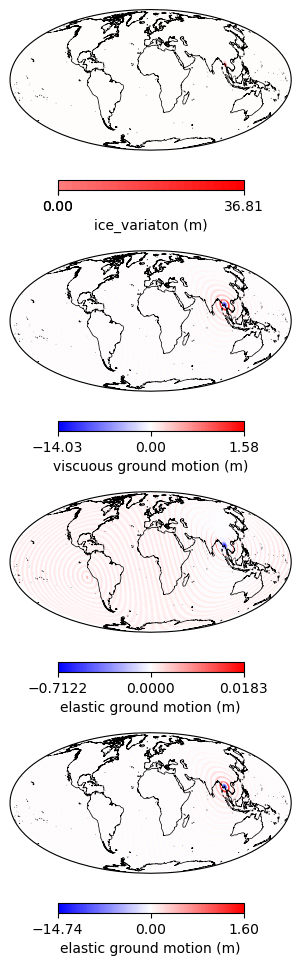

In [25]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors

cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm1 = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
ax1  = plt.subplot(411, projection=ccrs.Mollweide())
ax1.set_global()
colormap = cmap
m1 = ax1.imshow(sed_time_grid.height_time_grid[:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm1)
cbar1=plt.colorbar(mappable=m1, orientation="horizontal", shrink=0.2,ax=ax1)
cbar1.set_label('ice_variaton (m)')
cbar1.set_ticks([sed_time_grid.height_time_grid[:t_it,:,:].sum(0).min(), 0, sed_time_grid.height_time_grid[:t_it,:,:].sum(0).max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm2 = colors.TwoSlopeNorm(vmin=hd_visc.min(),vmax=hd_visc.max(),vcenter=0)
ax2  = plt.subplot(412, projection=ccrs.Mollweide())
ax2.set_global()
colormap = cmap
m2 = ax2.imshow(hd_visc, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm2)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.2,ax=ax2)
cbar2.set_label('viscuous ground motion (m)')
cbar2.set_ticks([hd_visc.min(), 0, hd_visc.max()])
ax2.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax2.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm3 = colors.TwoSlopeNorm(vmin=hd_elast.min(),vmax=hd_elast.max(),vcenter=0)
ax3  = plt.subplot(413, projection=ccrs.Mollweide())
ax3.set_global()
colormap = cmap
m3 = ax3.imshow(hd_elast, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
cbar3.set_label('elastic ground motion (m)')
cbar3.set_ticks([hd_elast.min(), 0, hd_elast.max()])
ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm4 = colors.TwoSlopeNorm(vmin=total_subsidence.min(),vmax=total_subsidence.max(),vcenter=0)
ax4  = plt.subplot(414, projection=ccrs.Mollweide())
ax4.set_global()
colormap = cmap
m4 = ax4.imshow(total_subsidence, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm4)
cbar4=plt.colorbar(mappable=m4, orientation="horizontal", shrink=0.2,ax=ax4)
cbar4.set_label('elastic ground motion (m)')
cbar4.set_ticks([total_subsidence.min(), 0, total_subsidence.max()])
ax4.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax4.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [44]:
fig.savefig('sed_test.pdf')

In [58]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")
for t_it in range (sed_time_grid.time_step_number) :
    norm3 = colors.TwoSlopeNorm(vmin=-1,vmax=100,vcenter=0)
    ax3  = plt.subplot(111, projection=ccrs.Mollweide())
    ax3.set_global()
    colormap = cmap
    m3 = ax3.imshow(sed_time_grid.height_time_grid[:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
    cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
    cbar3.set_label('elastic ground motion at ' + str(sed_time_grid.time_step[t_it]) + ' (m)')
    cbar3.set_ticks([-1,0,100])
    ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
    ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)
    fig.savefig('Results_sed/sed'+str(t_it))

    plt.clf()

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_23364\138224163.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


<Figure size 1200x1200 with 0 Axes>

In [26]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")
for t_it in range (sed_time_grid.time_step_number) :
    if t_it==0:
        hd_visc=np.zeros((1025,1025*2))
    elif t_it==1 :
        load.calc_viscuous_load(-sed_time_grid.height_time_coeff[0]*sed_time_grid.rho,love_number.beta_l,t_it-1)
        load.V_lm.maxdeg=64
        load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
        hd_visc=load.V_lm.coefftogrdhd(1024)
    else :
        load.calc_viscuous_load(-sed_time_grid.height_time_coeff[:t_it-1]*sed_time_grid.rho,love_number.beta_l,t_it-1)
        load.V_lm.maxdeg=64
        load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
        hd_visc=load.V_lm.coefftogrdhd(1024)
    if t_it==0 :
        subs_e=sphericalobject(coeff=-sed_time_grid.height_time_coeff[0]*sed_time_grid.rho*(love_number.k-love_number.h)*love_number.T.coeff)
    else :
        subs_e=sphericalobject(coeff=-sed_time_grid.height_time_coeff[:t_it].sum(0)*sed_time_grid.rho*(love_number.k-love_number.h)*love_number.T.coeff)
    subs_e.maxdeg=64
    hd_elast=subs_e.coefftogrdhd(1024)

    total_subs=hd_elast+hd_visc

    norm3 = colors.TwoSlopeNorm(vmin=-20,vmax=2,vcenter=0)
    ax3  = plt.subplot(111, projection=ccrs.Mollweide())
    ax3.set_global()
    colormap = cmap
    m3 = ax3.imshow(total_subs, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
    # if t_it==0 :
    #     c=ax3.contour(sed_time_grid.elons,sed_time_grid.lats[::-1],sed_time_grid.height_time_grid[0,:,:],[0],linewidths=2,transform=ccrs.PlateCarree(),colors='b')
    # else :
    #     c=ax3.contour(sed_time_grid.elons,ice_time_grid.lats[::-1],sed_time_grid.height_time_grid[:t_it,:,:].sum(0),[0],linewidths=2,transform=ccrs.PlateCarree())
    #ax3.plot([-100,-200],[-100,-200],linewidth=2,color='b',label='ice extent')
    cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
    cbar3.set_label('elastic ground motion at ' + str(sed_time_grid.time_step[t_it]) + ' (m)')
    cbar3.set_ticks([-20, 0, 2])
    ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
    ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)
    # ax3.legend()
    fig.savefig('Results_sed_def/ice'+str(t_it))

    plt.clf()

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_1656\2616275074.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


<Figure size 1200x1200 with 0 Axes>